In [1]:
"""
    Copyright (C) 2022 Francesca Meneghello
    contact: meneghello@dei.unipd.it
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""

'\n    Copyright (C) 2022 Francesca Meneghello\n    contact: meneghello@dei.unipd.it\n    This program is free software: you can redistribute it and/or modify\n    it under the terms of the GNU General Public License as published by\n    the Free Software Foundation, either version 3 of the License, or\n    (at your option) any later version.\n    This program is distributed in the hope that it will be useful,\n    but WITHOUT ANY WARRANTY; without even the implied warranty of\n    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the\n    GNU General Public License for more details.\n    You should have received a copy of the GNU General Public License\n    along with this program.  If not, see <https://www.gnu.org/licenses/>.\n'

In [2]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

from utilities import *
from Inceptionv4 import *
#from ResNet18 import *
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AvgPool2d, Linear, Dropout, CrossEntropyLoss
from torch.optim import SGD, Adam
from tqdm import tqdm
import torch.optim as optim
from copy import deepcopy

In [3]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a' #Subdirs for training
feature_length_init = 100 #Length along the feature dimension (height)
sample_length_init = 340 #Length along the time dimension (width)
channels_init = 1 #Number of channels
batch_size_init = 128 #Number of samples in a batch
num_tot_init = 4 #Number of antenna * number of spatial streams
name_base_init = 'single_ant' #Name base for the files
activities_init = 'E,L,W,R,J' #Activities to be considered
bandwidth_init = 80 #Bandwidth in [MHz] to select the subcarriers, can be 20, 40, 80 (default 80)
sub_band_init = 1 #Sub_band idx in [1, 2, 3, 4] for 20 MHz, [1, 2] for 40 MHz (default 1)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
# Set seeds for reproducibility
# fix this
seed = 203
torch.manual_seed(seed)

#### Create datasets for training, validation and test
Generate the datasets using the ``create dataset single`` function which returns a DataLoader object

In [6]:
#dataset_csi_train, dataset_csi_val, dataset_csi_test = create_dataloader_training(dir=dir_init, subdirs_training=subdirs_init, feature_length=feature_length_init, sample_length=sample_length_init, channels=channels_init, batch_size=batch_size_init,
#                               num_antennas=num_tot_init, name_base=name_base_init, csi_act=activities_init, bandwidth=bandwidth_init, sub_band=sub_band_init)

In [9]:
dir=dir_init
subdirs_training=subdirs_init
feature_length=feature_length_init
sample_length=sample_length_init
channels=channels_init
batch_size=batch_size_init
num_antennas=num_tot_init
name_base=name_base_init
csi_act=activities_init
bandwidth=bandwidth_init
sub_band=sub_band_init

doppler_transforms = DopplerTransformations(n_views=2)

activities = []
for lab_act in csi_act.split(','):
    activities.append(lab_act)
activities = np.asarray(activities)

if os.path.exists(name_base + '_' + str(csi_act) + '_cache_train.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_train.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_train.index')
if os.path.exists(name_base + '_' + str(csi_act) + '_cache_val.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_val.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_val.index')
if os.path.exists(name_base + '_' + str(csi_act) + '_cache_train_test.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_train_test.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_train_test.index')
if os.path.exists(name_base + '_' + str(csi_act) + '_cache_test.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_test.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_test.index')

labels_train = []
all_files_train = []
labels_val = []
all_files_val = []
labels_test = []
all_files_test = []
input_shape = (num_antennas, sample_length, feature_length, channels)
input_network = (sample_length, feature_length, channels)
output_shape = activities.shape[0]
labels_considered = np.arange(output_shape)
activities = activities[labels_considered]

suffix = '.txt'

for sdir in subdirs_training.split(','):
    exp_save_dir = dir + sdir + '/'
    
    dir_train = dir + sdir + '/train_antennas_' + str(csi_act) + '/'
    name_labels = dir + sdir + '/labels_train_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_train.extend(pickle.load(fp))
    name_f = dir + sdir + '/files_train_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_train.extend(pickle.load(fp))

    dir_val = dir + sdir + '/val_antennas_' + str(csi_act) + '/'
    name_labels = dir + sdir + '/labels_val_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_val.extend(pickle.load(fp))
    name_f = dir + sdir + '/files_val_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_val.extend(pickle.load(fp))

    dir_test = dir + sdir + '/test_antennas_' + str(csi_act) + '/'
    name_labels = dir + sdir + '/labels_test_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_test.extend(pickle.load(fp))
    name_f = dir + sdir + '/files_test_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_test.extend(pickle.load(fp))


file_train_selected = [all_files_train[idx] for idx in range(len(labels_train)) if labels_train[idx] in
                        labels_considered]
labels_train_selected = [labels_train[idx] for idx in range(len(labels_train)) if labels_train[idx] in
                            labels_considered]

file_train_selected_expanded, labels_train_selected_expanded, stream_ant_train = \
    expand_antennas(file_train_selected, labels_train_selected, num_antennas)

# create the batches
name_cache = name_base + '_' + str(csi_act) + '_cache_train'
dataset_csi_train = create_dataset_single(file_train_selected_expanded, labels_train_selected_expanded,
                                            stream_ant_train, input_network, batch_size,
                                            shuffle=True, drop_last=True, transform=doppler_transforms)

file_val_selected = [all_files_val[idx] for idx in range(len(labels_val)) if labels_val[idx] in
                        labels_considered]
labels_val_selected = [labels_val[idx] for idx in range(len(labels_val)) if labels_val[idx] in
                        labels_considered]

file_val_selected_expanded, labels_val_selected_expanded, stream_ant_val = \
    expand_antennas(file_val_selected, labels_val_selected, num_antennas)

name_cache_val = name_base + '_' + str(csi_act) + '_cache_val'
dataset_csi_val = create_dataset_single(file_val_selected_expanded, labels_val_selected_expanded,
                                        stream_ant_val, input_network, batch_size,
                                        shuffle=False, transform=doppler_transforms)

file_test_selected = [all_files_test[idx] for idx in range(len(labels_test)) if labels_test[idx] in
                        labels_considered]
labels_test_selected = [labels_test[idx] for idx in range(len(labels_test)) if labels_test[idx] in
                        labels_considered]

file_test_selected_expanded, labels_test_selected_expanded, stream_ant_test = \
    expand_antennas(file_test_selected, labels_test_selected, num_antennas)

name_cache_test = name_base + '_' + str(csi_act) + '_cache_test'
dataset_csi_test = create_dataset_single(file_test_selected_expanded, labels_test_selected_expanded,
                                            stream_ant_test, input_network, batch_size,
                                            shuffle=False, transform=doppler_transforms)

#### Define and train the model

In [21]:
'''
# Define training hyperparameters
batch_size=256
hidden_dim=128
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 100

# Define Loaders
#train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
#                                drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
#val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
#                                drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

# Define SimCLR Model
model = Inceptionv4(hidden_dim)

# Define Optimizer and Learning rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_top5_accs = []
val_top5_accs = []

print(model(torch.zeros((6, 1, 340, 100))).shape)
'''

'\n# Define training hyperparameters\nbatch_size=256\nhidden_dim=128\ntemperature=0.07\nweight_decay=1e-4\nmax_epochs=500\nlr=2e-4\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\n\nepochs = 100\n\n# Define Loaders\n#train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,\n#                                drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)\n#val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,\n#                                drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)\n\n# Define SimCLR Model\nmodel = Inceptionv4(hidden_dim)\n\n# Define Optimizer and Learning rate Scheduler\noptimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)\nlr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)\n\n# Training Loop\ntrain_losses = []\nval_losses = []\ntrain_top5_accs = []\nval_top5_accs = []\n\nprint(model(torch.zeros((6, 1

Queste funzioni poi andranno riportate nel file utilities

In [60]:
def train_contrastive(model, device, train_loader, optimizer, lr_scheduler, epoch, loss_temperature):
    train_losses = []
    train_top1_accs = []

    model.train()
    model.to(device)
    for i, batch in enumerate(train_loader):
        imgs, _ = batch

        # Concatenate the two images along the batch dimension, so we get a tensor of shape (BatchDim * 2, 3, 96, 96)
        # Also remember to put the images on the GPU
        cat_imgs = torch.cat(imgs, dim=0).to(device)

        # Compute the features
        features = model(cat_imgs)

        # Compute the loss together with the accuracy metrics, and store them in the lists above
        nce_loss, acc_top1, acc_top5 = NT_Xent_loss(features, temperature=loss_temperature)
        train_losses.append(nce_loss.item())
        train_top1_accs.append(acc_top1.item())

        # Backpropagate the loss and perform the optimization step
        optimizer.zero_grad()
        nce_loss.backward()
        optimizer.step()
        print(i)

    print(f"Train Epoch: {epoch},  \tLoss: {np.mean(train_losses).item():.6f}, \tTop1_Acc: {np.mean(train_top1_accs).item():.6f}")
    lr_scheduler.step()
    return np.mean(train_losses), np.mean(train_top1_accs)

In [61]:
def valid_constrastive(model, device, val_loader, epoch, loss_temperature):
    model.eval()
    with torch.no_grad():
        val_losses = []
        val_top1_accs = []
        for i, batch in enumerate(val_loader):
            imgs, _ = batch

            # Concatenate the images
            imgs = torch.cat(imgs, dim=0).to(device)

            # Compute the features
            features = model(imgs)

            # Compute loss and accuracies, and store them
            nce_loss, acc_top1, acc_top5 = NT_Xent_loss(features, temperature=loss_temperature)
            val_losses.append(nce_loss.item())
            val_top1_accs.append(acc_top1.item())
            
        print(f"Valid Epoch: {epoch},  \tLoss: {np.mean(val_losses).item():.6f}, \tTop1_Acc: {np.mean(val_top1_accs).item():.6f}")   
    return np.mean(val_losses), np.mean(val_top1_accs)

In [62]:
def NT_Xent_loss(features_batch, temperature, mode='train'):
    """
    Takes in input a features_batch tensor of shape (BatchSize * 2, feature_dim), the temperature parameter,
    and computes the NT_Xent_loss
    """

    # Calculate cosine similarity between all possible couples of examples in the features_batch tensor
    # Result must be a (BatchSize*2, BatchSize*2) tensor
    # Hints:
    # 1) Check the documentation https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html
    # 2) Use broadcasting!

    cos_sim = F.cosine_similarity(features_batch[:,None,:], features_batch[None,:,:], dim=-1)

    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)

    # Find the positive example, we know that it is batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

    # NT_Xent loss
    cos_sim = cos_sim / temperature

    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    # Get ranking position of positive example
    comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                            cos_sim.masked_fill(pos_mask, -9e15)],
                            dim=-1)
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    acc_top1 = (sim_argsort == 0).float().mean()
    acc_top5 = (sim_argsort < 5).float().mean()

    return nll, acc_top1, acc_top5

In [47]:
# Define training hyperparameters
batch_size=128
hidden_dim=16
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 100
CHECKPOINT_PATH = "./saved_models"
# Define Loaders
#train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
#                                drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
#val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
#                                drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

# Define SimCLR Model
model = ResNet18(hidden_dim)

# Define Optimizer and Learning rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_top1_accs = []
val_top1_accs = []


for epoch in range(epochs):
    # Training iterations and update lists
    train_loss, train_top1_acc = train_contrastive(model, device, dataset_csi_train, optimizer, lr_scheduler, epoch, loss_temperature=temperature)
    train_losses.append(train_loss)
    train_top1_accs.append(train_top1_acc)
    print()

    # Validation iterations
    val_loss, val_top1_acc = valid_constrastive(model, device, dataset_csi_val, epoch, loss_temperature=temperature)
    val_losses.append(val_loss)
    val_top1_accs.append(val_top1_acc)
    print()

# Save the model
torch.save(model.state_dict(), os.path.join(CHECKPOINT_PATH, 'My_ResNet18_hd16_bs128.ckpt'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
Train Epoch: 0,  	Loss: 2.016623, 	Top1_Acc: 0.610073

Valid Epoch: 0,  	Loss: 2.397161, 	Top1_Acc: 0.668345

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
Train Epoch: 1,  	Loss: 0.914674, 	Top1_Acc: 0.806292

Valid Epoch: 1,  	Loss: 1.590237, 	Top1_Acc: 0.749132

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
Train Epoch: 2,  	Loss: 0.799963, 	Top1_Acc: 0.814174

Valid Epoch: 2,  	Loss: 1.568352, 	Top1_Acc: 0.759332

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
Train Epoch: 3,  	Loss: 0.768253, 	Top

Now let's see the behaviour of accuracies and loss function

In [17]:
CHECKPOINT_PATH = "./saved_models"
# Save the model
#torch.save(model.state_dict(), os.path.join(CHECKPOINT_PATH, 'My_Inception_hd46_bs128.ckpt'))

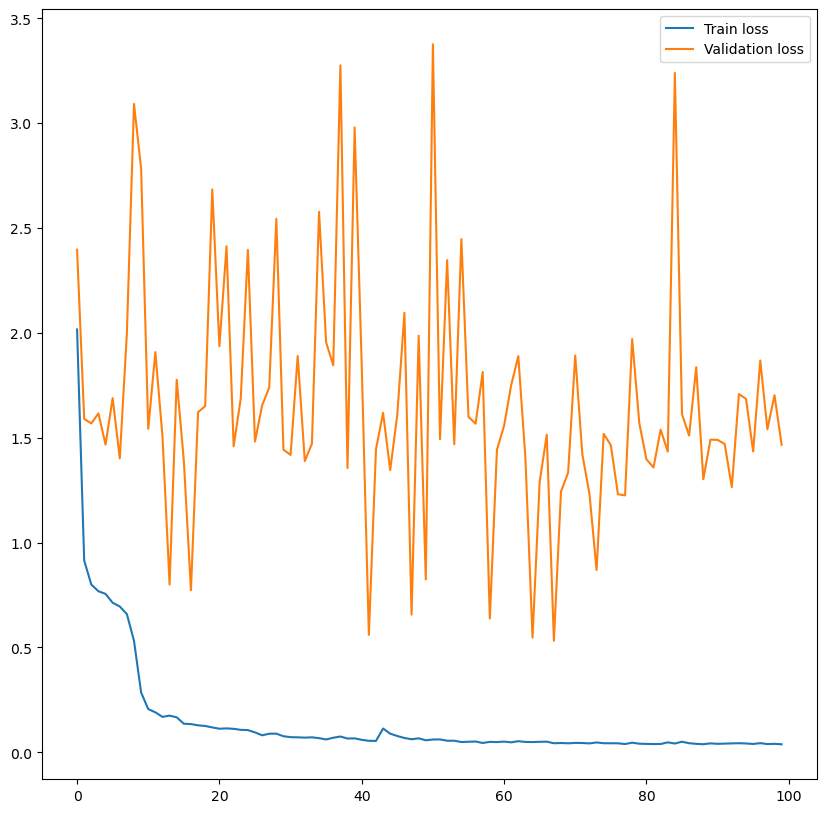

In [50]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

In [63]:
# Define training hyperparameters
batch_size=64
hidden_dim=16
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
# Define SimCLR Model
model = ResNet18(hidden_dim)
CHECKPOINT_PATH = "./saved_models"
## Load the pre-trained model here
## (Note: if you get an error here, you have some mistakes in the SimCLR model class definition.)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "My_ResNet18_hd16_bs128.ckpt")))

C:\Users\feder\AppData\Local\Temp\ipykernel_24124\4098915907.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PA

<All keys matched successfully>

In [39]:
model.classification_layer = nn.Identity()

In [69]:
print(model)

ResNet18(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=valid)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvolutionalBlock(
      (main_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (shortcut_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): IdentityBlock(
      (main_path): Sequential(
        (

In [53]:
model.to("cpu")
model.eval()
print(model(torch.zeros((6, 1, 340, 100))))

tensor([[ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  

In [65]:
#model.to("cpu")
model.eval()
print(model(torch.zeros((6, 1, 340, 100))))

tensor([[ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  -3.5072,   3.8023,
          15.7796, -13.4938, -12.0269,  -7.6538,   8.4333,   1.5677,  10.3364,
           4.7000,  -8.8305],
        [ -8.8063,   5.1511,   0.1804,  -4.2560, -14.5321,  

In [70]:
print(model.classification_layer)

Sequential(
  (0): Linear(in_features=2560, out_features=64, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=64, out_features=16, bias=True)
)


Now that we've trained our model, we can remove the final projection block, substituting it with another one, and we train that

In [77]:
class SimpleClassifier(nn.Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()

        #self.model = nn.Linear(feature_dim, num_classes)
        # Mapping from representation h to classes with a linear layer
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 256),
        #    nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [10]:
subdirs_training = subdirs_init  # string
labels_train = []
all_files_train = []
labels_val = []
all_files_val = []
labels_test = []
all_files_test = []
sample_length = sample_length_init
feature_length = feature_length_init
channels = channels_init
num_antennas = num_tot_init
input_shape = (num_antennas, sample_length, feature_length, channels)
input_network = (sample_length, feature_length, channels)
batch_size = batch_size_init
output_shape = activities.shape[0]
labels_considered = np.arange(output_shape)
activities = activities[labels_considered]

suffix = '.txt'

for sdir in subdirs_training.split(','):
    exp_save_dir = dir_init + sdir + '/'
    
    dir_train = dir_init + sdir + '/train_antennas_' + str(csi_act) + '/'
    name_labels = dir_init + sdir + '/labels_train_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_train.extend(pickle.load(fp))
    name_f = dir_init + sdir + '/files_train_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_train.extend(pickle.load(fp))

    dir_val = dir_init + sdir + '/val_antennas_' + str(csi_act) + '/'
    name_labels = dir_init + sdir + '/labels_val_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_val.extend(pickle.load(fp))
    name_f = dir_init + sdir + '/files_val_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_val.extend(pickle.load(fp))

    dir_test = dir_init + sdir + '/test_antennas_' + str(csi_act) + '/'
    name_labels = dir_init + sdir + '/labels_test_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_test.extend(pickle.load(fp))
    name_f = dir_init + sdir + '/files_test_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_test.extend(pickle.load(fp))


file_train_selected = [all_files_train[idx] for idx in range(len(labels_train)) if labels_train[idx] in
                        labels_considered]
labels_train_selected = [labels_train[idx] for idx in range(len(labels_train)) if labels_train[idx] in
                            labels_considered]

file_train_selected_expanded, labels_train_selected_expanded, stream_ant_train = \
    expand_antennas(file_train_selected, labels_train_selected, num_antennas)

# create the batches
name_cache = name_base + '_' + str(csi_act) + '_cache_train'
dataset_csi_train2 = create_dataset_single(file_train_selected_expanded, labels_train_selected_expanded,
                                            stream_ant_train, input_network, batch_size,
                                            shuffle=True)

file_val_selected = [all_files_val[idx] for idx in range(len(labels_val)) if labels_val[idx] in
                        labels_considered]
labels_val_selected = [labels_val[idx] for idx in range(len(labels_val)) if labels_val[idx] in
                        labels_considered]

file_val_selected_expanded, labels_val_selected_expanded, stream_ant_val = \
    expand_antennas(file_val_selected, labels_val_selected, num_antennas)

name_cache_val = name_base + '_' + str(csi_act) + '_cache_val'
dataset_csi_val2 = create_dataset_single(file_val_selected_expanded, labels_val_selected_expanded,
                                        stream_ant_val, input_network, batch_size,
                                        shuffle=False)

file_test_selected = [all_files_test[idx] for idx in range(len(labels_test)) if labels_test[idx] in
                        labels_considered]
labels_test_selected = [labels_test[idx] for idx in range(len(labels_test)) if labels_test[idx] in
                        labels_considered]

file_test_selected_expanded, labels_test_selected_expanded, stream_ant_test = \
    expand_antennas(file_test_selected, labels_test_selected, num_antennas)

name_cache_test = name_base + '_' + str(csi_act) + '_cache_test'
dataset_csi_test2 = create_dataset_single(file_test_selected_expanded, labels_test_selected_expanded,
                                            stream_ant_test, input_network, batch_size,
                                            shuffle=False)

In [11]:
import torch.utils


def prepare_data_features(model, dataset):
    with torch.no_grad():
        # Prepare model
        model.classification_layer = nn.Identity()  # Removing projection head g(.)
        model.eval()
        model.to(device)

        # Encode all images
        feats, labels = [], []
        for batch_imgs, batch_labels in tqdm(dataset):
            batch_imgs = batch_imgs.to(device)
            batch_feats = model(batch_imgs)
            feats.append(batch_feats.detach().cpu())
            labels.append(batch_labels)

        feats = torch.cat(feats, dim=0)
        labels = torch.cat(labels, dim=0)

        # Sort images by labels
        #labels, idxs = labels.sort()
        #feats = feats[idxs]
        #feats = feats.permute(0, 2, 1)


    return TensorDataset(feats, labels)

In [72]:
train_feats = prepare_data_features(model, dataset_csi_train2)
test_feats = prepare_data_features(model, dataset_csi_test2)
val_feats = prepare_data_features(model, dataset_csi_val2)

100%|██████████| 18/18 [00:02<00:00,  8.35it/s]


In [73]:
feats, labels = train_feats.tensors  # Accedi ai tensori contenuti nel TensorDataset
print(feats.shape)
print(labels)


torch.Size([7220, 2560])
tensor([[2],
        [3],
        [1],
        ...,
        [3],
        [1],
        [1]])


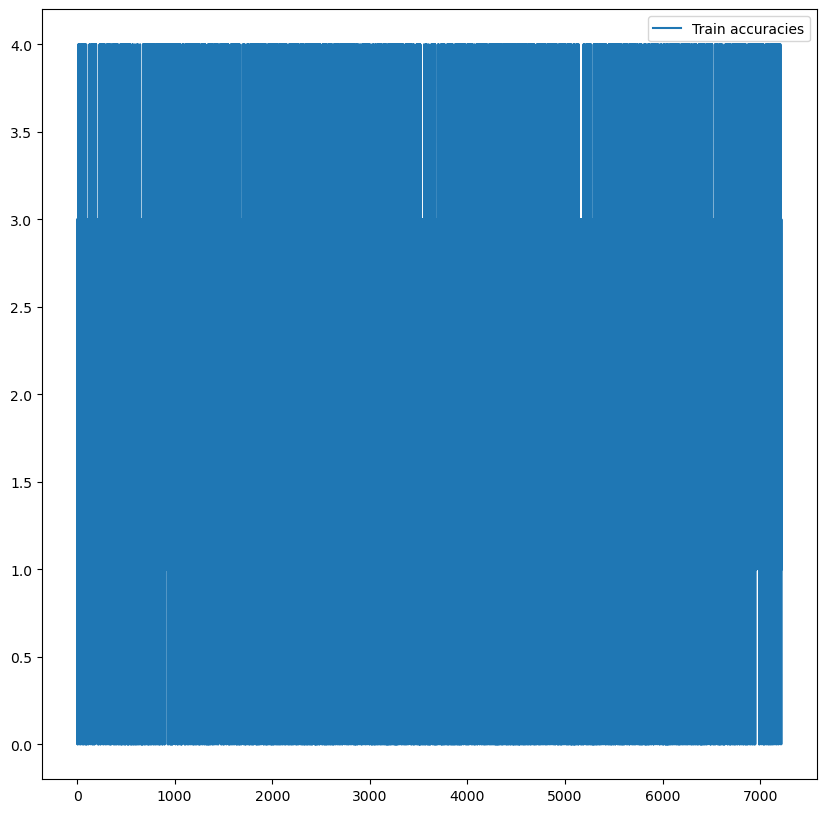

In [74]:
plt.figure(figsize=(10,10))
plt.plot(labels, label="Train accuracies")
plt.legend()

plt.show()

In [78]:
def train_classifier(batch_size, train_feats_data, test_feats_data, feature_dim, max_epochs=1000):

    # Define the simple classifier model here, the number of classes in the dataset is 10
    model = SimpleClassifier(feature_dim, num_classes=5)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False)

    tlosses = []
    taccs = []
    tlossestest = []
    taccstest = []
    loss_fn = CrossEntropyLoss()

    best_test_acc = 0
    for epoch in range(max_epochs):
        losses = []
        accs = []
        model.train()
        for batch in train_loader:
            feats, labels = batch
            feats = feats.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1)
            #print(labels.shape)

            # Forward pass
            preds = model(feats)
            #preds = t.squeeze(preds, dim=1)
            #print(preds.shape)

            # Compute the cross entropy loss
            loss = F.cross_entropy(preds, labels)

            acc = (preds.argmax(dim=-1) == labels).float().mean()

            losses.append(loss.item())
            accs.append(acc.item())

            # Backpropagate the loss and perform the optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        tlosses.append(np.mean(losses))
        taccs.append(np.mean(accs))

        print(f"Epoch: {epoch}, Train Loss: {tlosses[-1]:.6f}, Train Accuracy: {taccs[-1]:.6f}")


        model.eval()
        with torch.no_grad():
            testlosses = []
            testaccs = []
            model.eval()
            for batch in test_loader:
                feats, labels = batch
                feats = feats.to(device)
                labels = labels.to(device)
                labels = labels.squeeze(dim=1)
                #print(labels.shape)

                # Forward pass
                preds = model(feats)
                #preds = t.squeeze(preds, dim=1)
                #print(preds.shape)

                # Compute the cross entropy loss
                loss = F.cross_entropy(preds, labels)

                acc = (preds.argmax(dim=-1) == labels).float().mean()

                testlosses.append(loss.item())
                testaccs.append(acc.item())

            tlossestest.append(np.mean(testlosses))
            taccstest.append(np.mean(testaccs))
            print(f"Epoch: {epoch}, Val Loss: {tlossestest[-1]:.6f}, Val Accuracy: {taccstest[-1]:.6f}")

        '''
        if epoch%10 == 0:
            ## Test set
            print()
            test_acc = []
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    feats, labels = batch
                    feats = feats.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    preds = model(feats)
                    acc = (preds.argmax(dim=-1) == labels).float().mean()
                    test_acc.append(acc.item())

                test_acc = np.mean(test_acc)
                if test_acc > best_test_acc:
                    best_test_acc = test_acc.item()
                else:
                    print("Early stop at epoch ", epoch)
                    break
        '''
    return model, tlosses, taccs, tlossestest, taccstest

In [79]:
batch_size=64
num_classes=5
lr=1e-3
weight_decay=1e-3


_, train_losses, train_accs, val_losses, val_accs = train_classifier(batch_size=64,
                                    train_feats_data=train_feats,
                                    test_feats_data=test_feats,
                                    feature_dim=2560)


Epoch: 0, Train Loss: 0.991023, Train Accuracy: 0.694339
Epoch: 0, Val Loss: 0.564910, Val Accuracy: 0.784821
Epoch: 1, Train Loss: 0.364607, Train Accuracy: 0.834624
Epoch: 1, Val Loss: 0.385234, Val Accuracy: 0.822470
Epoch: 2, Train Loss: 0.323566, Train Accuracy: 0.848568
Epoch: 2, Val Loss: 0.356250, Val Accuracy: 0.849554
Epoch: 3, Train Loss: 0.296617, Train Accuracy: 0.863321
Epoch: 3, Val Loss: 0.478475, Val Accuracy: 0.835565
Epoch: 4, Train Loss: 0.266893, Train Accuracy: 0.877882
Epoch: 4, Val Loss: 0.493279, Val Accuracy: 0.805804
Epoch: 5, Train Loss: 0.254874, Train Accuracy: 0.886604
Epoch: 5, Val Loss: 0.414954, Val Accuracy: 0.836905
Epoch: 6, Train Loss: 0.245348, Train Accuracy: 0.892550
Epoch: 6, Val Loss: 0.433580, Val Accuracy: 0.836458
Epoch: 7, Train Loss: 0.230416, Train Accuracy: 0.896901
Epoch: 7, Val Loss: 0.344529, Val Accuracy: 0.867857
Epoch: 8, Train Loss: 0.253739, Train Accuracy: 0.887487
Epoch: 8, Val Loss: 0.432987, Val Accuracy: 0.856845
Epoch: 9, 

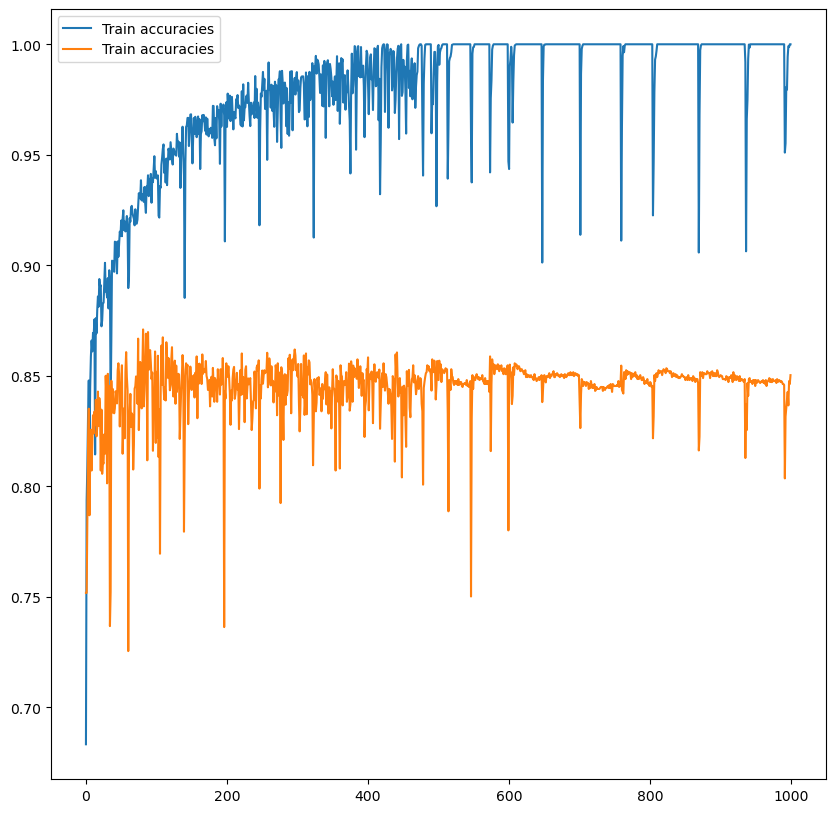

In [32]:
plt.figure(figsize=(10,10))
plt.plot(train_accs, label="Train accuracies")
plt.plot(val_accs, label="Train accuracies")
plt.legend()

plt.show()

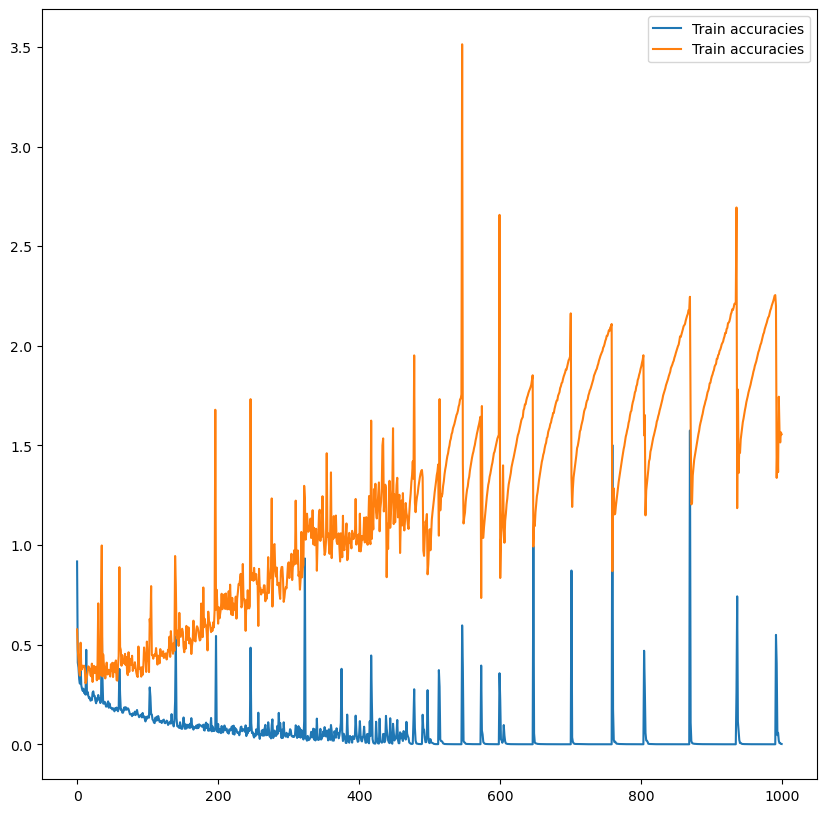

In [33]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label="Train accuracies")
plt.plot(val_losses, label="Train accuracies")
plt.legend()

plt.show()

In [12]:
#########################################################################################################################################################################################################################################

From now on there is the part with supervised training, in orther to have a first check and compare what shown in the paper with a given model

In [8]:
import json

In [ ]:
model = Inceptionv4()
opt = Adam(model.parameters(), lr=0.0001)
loss_fn = CrossEntropyLoss() # by default reduction="mean" i.e. the output is a scalar
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
CHECKPOINT_PATH = "./saved_models"
epochs=400
best_val = np.inf
iteration = 0
train_error = []
validation_error = []
for epoch in range(epochs):
    train_loss = []
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(dataset_csi_train2) # iterate over the batches
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device) # batch with the inputs
        batch_y = batch_y.to(device) # batch with the labels
        batch_y = t.squeeze(batch_y, dim=1)

        y_pred = model(batch_x) 

        loss = loss_fn(y_pred, batch_y)
 
        opt.zero_grad() 
        loss.backward() #how is it bound to the model?
        opt.step()
        train_loss.append(loss.detach().cpu().numpy())
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    train_error.append(np.mean(train_loss))

    # validation
    model.eval() # what does this change?
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataset_csi_val2):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y = t.squeeze(batch_y, dim=1)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        validation_error.append(val_loss.detach().cpu().numpy())

        val_acc = (torch.softmax(predictions, dim=1).argmax(dim=1) == true).float().mean()
        ###REMEMBER TO ADD CONFUSION MATRIX, KEEPING IN MIND TO PASS FROM CUDA TO CPU
        #conf_matrix_val = confusion_matrix(true, torch.softmax(predictions, dim=1).argmax(dim=1))
        #if true in argsort[:N] per top-N score?
        print(f"loss: {val_loss}, accuracy: {val_acc}")

    if val_loss < best_val:
        iteration = epoch
        print("Saved Model")
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_PATH, 'Complete_Inceptionv4_cross_entropy.ckpt'))
        best_val = val_loss

print("iteration with best score: ", iteration)
plt.figure(figsize=(10,10))
plt.plot(train_error, label="Train loss")
plt.plot(validation_error, label="Validation loss")
plt.legend()
plt.show()

# Dopo aver popolato train_error e validation_error nel ciclo:
errors = {
    "train_error": train_error,
    "validation_error": validation_error
}

with open('errors.json', 'w') as file:
    json.dump(errors, file, indent=4)  # indent=4 rende il file più leggibile

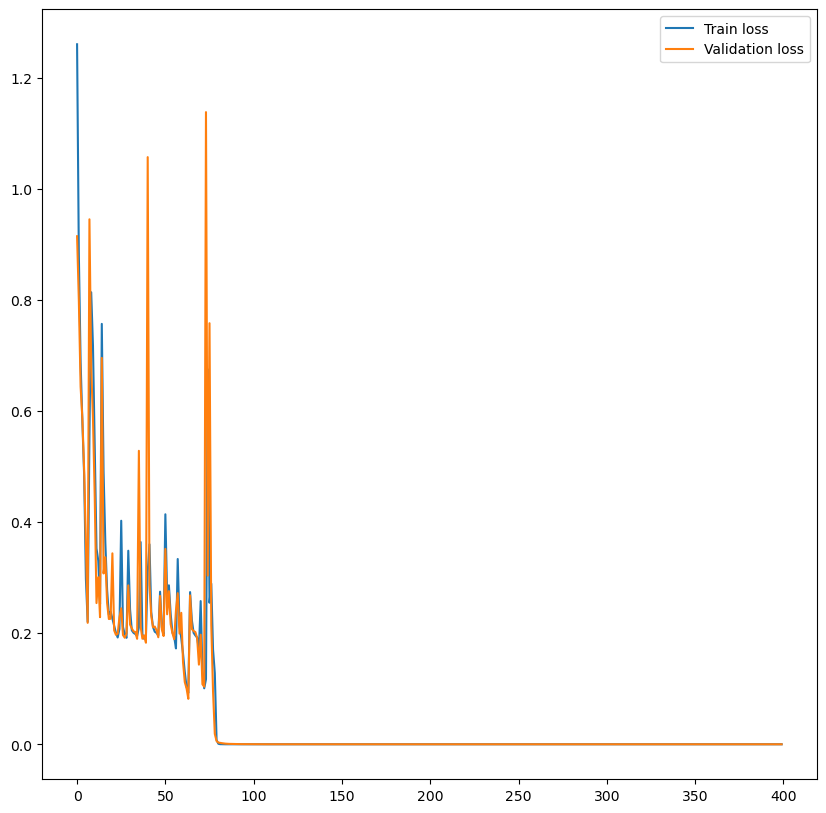

In [11]:
plt.figure(figsize=(10,10))
plt.plot(train_error, label="Train loss")
plt.plot(validation_error, label="Validation loss")
plt.legend()
plt.show()

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Define SimCLR Model
model = Inceptionv4()
CHECKPOINT_PATH = "./saved_models"
## Load the pre-trained model here
## (Note: if you get an error here, you have some mistakes in the SimCLR model class definition.)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "Complete_Inceptionv4_cross_entropy.ckpt")))

C:\Users\feder\AppData\Local\Temp\ipykernel_28864\1559847050.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PAT

<All keys matched successfully>

Now we proceed with the test of our trained model

In [14]:
device = "cuda"
model.to(device)
model.eval() # what does this change?
loss_fn = CrossEntropyLoss()
with torch.no_grad():
    predictions = []
    true = []
    for batch_x, batch_y in tqdm(dataset_csi_test2):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y = t.squeeze(batch_y, dim=1)

        y_pred = model(batch_x)

        predictions.append(y_pred)
        true.append(batch_y)
    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    print(predictions.shape)
    true = torch.cat(true, axis=0)
    test_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    test_prediction_list = torch.softmax(predictions, dim=1).detach().cpu()
    test_labels_pred = test_prediction_list.argmax(dim=1)
    test_acc = (test_labels_pred == true).float().mean()
    conf_matrix = confusion_matrix(true, test_labels_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(true,
                                                                   test_labels_pred,
                                                                   labels=labels_considered)
    accuracy = accuracy_score(true, test_labels_pred)
    #if true in argsort[:N] per top-N score?
    #print(f"loss: {test_loss}, accuracy: {test_acc}")
    print(f"loss: {test_loss}, accuracy: {accuracy}")
    print(test_prediction_list.shape)

100%|██████████| 18/18 [00:04<00:00,  3.82it/s]

torch.Size([2188, 5])
loss: 4.9369788030162454e-05, accuracy: 1.0
torch.Size([2188, 5])


In [16]:
print(len(labels_test_selected))

547


In [17]:
# merge antennas test
labels_true_merge = np.array(labels_test_selected)
pred_max_merge = np.zeros_like(labels_test_selected)
for i_lab in range(len(labels_test_selected)):
    pred_antennas = test_prediction_list[i_lab * num_antennas:(i_lab + 1) * num_antennas, :].numpy()
    #print(pred_antennas.shape)
    lab_merge_max = np.argmax(np.sum(pred_antennas, axis=0))
    #print(np.sum(pred_antennas, axis=0).shape)

    pred_max_antennas = test_labels_pred[i_lab * num_antennas:(i_lab + 1) * num_antennas]
    lab_unique, count = np.unique(pred_max_antennas, return_counts=True)
    lab_max_merge = -1
    if lab_unique.shape[0] > 1:
        count_argsort = np.flip(np.argsort(count))
        count_sort = count[count_argsort]
        lab_unique_sort = lab_unique[count_argsort]
        if count_sort[0] == count_sort[1] or lab_unique.shape[0] > 2:  # ex aequo between two labels
            lab_max_merge = lab_merge_max
        else:
            lab_max_merge = lab_unique_sort[0]
    else:
        lab_max_merge = lab_unique[0]
    pred_max_merge[i_lab] = lab_max_merge

conf_matrix_max_merge = confusion_matrix(labels_true_merge, pred_max_merge, labels=labels_considered)
precision_max_merge, recall_max_merge, fscore_max_merge, _ = \
    precision_recall_fscore_support(labels_true_merge, pred_max_merge, labels=labels_considered)
accuracy_max_merge = accuracy_score(labels_true_merge, pred_max_merge)

metrics_matrix_dict = {'conf_matrix': conf_matrix,
                        'accuracy_single': accuracy,
                        'precision_single': precision,
                        'recall_single': recall,
                        'fscore_single': fscore,
                        'conf_matrix_max_merge': conf_matrix_max_merge,
                        'accuracy_max_merge': accuracy_max_merge,
                        'precision_max_merge': precision_max_merge,
                        'recall_max_merge': recall_max_merge,
                        'fscore_max_merge': fscore_max_merge}

name_file = './outputs/test_' + str(csi_act) + '_' + subdirs_training + '_band_' + str(bandwidth) + '_subband_' + \
            str(sub_band) + suffix
with open(name_file, "wb") as fp:  # Pickling
    pickle.dump(metrics_matrix_dict, fp)

# impact of the number of antennas
one_antenna = [[0], [1], [2], [3]]
two_antennas = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
three_antennas = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
four_antennas = [[0, 1, 2, 3]]
seq_ant_list = [one_antenna, two_antennas, three_antennas, four_antennas]
average_accuracy_change_num_ant = np.zeros((num_antennas,))
average_fscore_change_num_ant = np.zeros((num_antennas,))
labels_true_merge = np.array(labels_test_selected)
for ant_n in range(num_antennas):
    seq_ant = seq_ant_list[ant_n]
    num_seq = len(seq_ant)
    for seq_n in range(num_seq):
        pred_max_merge = np.zeros((len(labels_test_selected),))
        ants_selected = seq_ant[seq_n]
        for i_lab in range(len(labels_test_selected)):
            pred_antennas = test_prediction_list[i_lab * num_antennas:(i_lab + 1) * num_antennas, :].numpy()
            pred_antennas = pred_antennas[ants_selected, :]

            lab_merge_max = np.argmax(np.sum(pred_antennas, axis=0))

            pred_max_antennas = test_labels_pred[i_lab * num_antennas:(i_lab + 1) * num_antennas]
            pred_max_antennas = pred_max_antennas[ants_selected]
            lab_unique, count = np.unique(pred_max_antennas, return_counts=True)
            lab_max_merge = -1
            if lab_unique.shape[0] > 1:
                count_argsort = np.flip(np.argsort(count))
                count_sort = count[count_argsort]
                lab_unique_sort = lab_unique[count_argsort]
                if count_sort[0] == count_sort[1] or lab_unique.shape[0] > ant_n - 1:  # ex aequo between two labels
                    lab_max_merge = lab_merge_max
                else:
                    lab_max_merge = lab_unique_sort[0]
            else:
                lab_max_merge = lab_unique[0]
            pred_max_merge[i_lab] = lab_max_merge

        _, _, fscore_max_merge, _ = precision_recall_fscore_support(labels_true_merge, pred_max_merge,
                                                                    labels=[0, 1, 2, 3, 4])
        accuracy_max_merge = accuracy_score(labels_true_merge, pred_max_merge)

        average_accuracy_change_num_ant[ant_n] += accuracy_max_merge
        average_fscore_change_num_ant[ant_n] += np.mean(fscore_max_merge)

    average_accuracy_change_num_ant[ant_n] = average_accuracy_change_num_ant[ant_n] / num_seq
    average_fscore_change_num_ant[ant_n] = average_fscore_change_num_ant[ant_n] / num_seq

metrics_matrix_dict = {'average_accuracy_change_num_ant': average_accuracy_change_num_ant,
                        'average_fscore_change_num_ant': average_fscore_change_num_ant}

name_file = './outputs/change_number_antennas_test_' + str(csi_act) + '_' + subdirs_training + '_band_' + \
            str(bandwidth) + '_subband_' + str(sub_band) + '.txt'
with open(name_file, "wb") as fp:  # Pickling
    pickle.dump(metrics_matrix_dict, fp)


In [18]:
# Example of target with class indices
# non capisco come funzioni tbh
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print("target tensor:", target)
output = loss(input, target)
output.backward()

# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
print("target tensor:", target)
output = loss(input, target)
output.backward()

target tensor: tensor([1, 4, 4])
target tensor: tensor([[0.3890, 0.0231, 0.0857, 0.3876, 0.1146],
        [0.6875, 0.0854, 0.0399, 0.1562, 0.0310],
        [0.1715, 0.3163, 0.0605, 0.0836, 0.3681]])


Now we proceed testing our model in the other sets, those not involved with the training part

In [30]:
subdirs_init = 'S4a,S4b' #Subdirs for testing our model

In [31]:
csi_act = activities_init
activities = []
for lab_act in csi_act.split(','):
    activities.append(lab_act)
activities = np.asarray(activities)

suffix = '.txt'

name_base = name_base_init
if os.path.exists(name_base + '_' + str(csi_act) + '_cache_complete.data-00000-of-00001'):
    os.remove(name_base + '_' + str(csi_act) + '_cache_complete.data-00000-of-00001')
    os.remove(name_base + '_' + str(csi_act) + '_cache_complete.index')

subdirs_complete = subdirs_init  # string
labels_complete = []
all_files_complete = []
sample_length = sample_length_init
feature_length = feature_length_init
channels = channels_init
num_antennas = num_tot_init
input_shape = (num_antennas, sample_length, feature_length, channels)
input_network = (sample_length, feature_length, channels)
batch_size = batch_size_init
output_shape = activities.shape[0]
labels_considered = np.arange(output_shape)
activities = activities[labels_considered]

for sdir in subdirs_complete.split(','):
    exp_save_dir = dir_init + sdir + '/'
    dir_complete = dir_init + sdir + '/complete_antennas_' + str(csi_act) + '/'
    name_labels = dir_init + sdir + '/labels_complete_antennas_' + str(csi_act) + suffix
    with open(name_labels, "rb") as fp:  # Unpickling
        labels_complete.extend(pickle.load(fp))
    name_f = dir_init + sdir + '/files_complete_antennas_' + str(csi_act) + suffix
    with open(name_f, "rb") as fp:  # Unpickling
        all_files_complete.extend(pickle.load(fp))

file_complete_selected = [all_files_complete[idx] for idx in range(len(labels_complete)) if labels_complete[idx] in
                            labels_considered]
labels_complete_selected = [labels_complete[idx] for idx in range(len(labels_complete)) if labels_complete[idx] in
                            labels_considered]

file_complete_selected_expanded, labels_complete_selected_expanded, stream_ant_complete = \
    expand_antennas(file_complete_selected, labels_complete_selected, num_antennas)

dataset_csi_complete = create_dataset_single(file_complete_selected_expanded, labels_complete_selected_expanded,
                                                stream_ant_complete, input_network, batch_size, shuffle=False,)


model.eval() # what does this change?
with torch.no_grad():
    predictions = []
    true = []
    for batch_x, batch_y in tqdm(dataset_csi_complete):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y = t.squeeze(batch_y, dim=1)

        y_pred = model(batch_x)

        predictions.append(y_pred)
        true.append(batch_y)
    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    complete_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    complete_prediction_list = torch.softmax(predictions, dim=1).detach().cpu()
    complete_labels_pred = complete_prediction_list.argmax(dim=1)
    complete_acc = (complete_labels_pred == true).float().mean()
    conf_matrix = confusion_matrix(true, complete_labels_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(true,
                                                                   complete_labels_pred,
                                                                   labels=labels_considered)
    accuracy = accuracy_score(true, complete_labels_pred)
    #if true in argsort[:N] per top-N score?
    #print(f"loss: {test_loss}, accuracy: {test_acc}")
    print(f"loss: {complete_loss}, accuracy: {accuracy}")
    print(complete_prediction_list.shape)


# merge antennas
labels_true_merge = np.array(labels_complete_selected)
pred_max_merge = np.zeros_like(labels_complete_selected)
for i_lab in range(len(labels_complete_selected)):
    pred_antennas = complete_prediction_list[i_lab*num_antennas:(i_lab+1)*num_antennas, :].numpy()
    sum_pred = np.sum(pred_antennas, axis=0)
    lab_merge_max = np.argmax(sum_pred)

    pred_max_antennas = complete_labels_pred[i_lab*num_antennas:(i_lab+1)*num_antennas]
    lab_unique, count = np.unique(pred_max_antennas, return_counts=True)
    lab_max_merge = -1
    if lab_unique.shape[0] > 1:
        count_argsort = np.flip(np.argsort(count))
        count_sort = count[count_argsort]
        lab_unique_sort = lab_unique[count_argsort]
        if count_sort[0] == count_sort[1] or lab_unique.shape[0] > 2:  # ex aequo between two labels
            lab_max_merge = lab_merge_max
        else:
            lab_max_merge = lab_unique_sort[0]
    else:
        lab_max_merge = lab_unique[0]
    pred_max_merge[i_lab] = lab_max_merge

print(labels_true_merge.shape, pred_max_merge.shape)

conf_matrix_max_merge = confusion_matrix(labels_true_merge, pred_max_merge, labels=labels_considered)
precision_max_merge, recall_max_merge, fscore_max_merge, _ = \
    precision_recall_fscore_support(labels_true_merge, pred_max_merge, labels=labels_considered)
accuracy_max_merge = accuracy_score(labels_true_merge, pred_max_merge)

metrics_matrix_dict = {'conf_matrix': conf_matrix,
                        'accuracy_single': accuracy,
                        'precision_single': precision,
                        'recall_single': recall,
                        'fscore_single': fscore,
                        'conf_matrix_max_merge': conf_matrix_max_merge,
                        'accuracy_max_merge': accuracy_max_merge,
                        'precision_max_merge': precision_max_merge,
                        'recall_max_merge': recall_max_merge,
                        'fscore_max_merge': fscore_max_merge}

name_file = './outputs/complete_different_' + str(csi_act) + '_' + subdirs_complete + '_band_' + str(bandwidth) \
            + '_subband_' + str(sub_band) + suffix
with open(name_file, "wb") as fp:  # Pickling
    pickle.dump(metrics_matrix_dict, fp)
print('accuracy', accuracy_max_merge)
print('fscore', fscore_max_merge)
print(conf_matrix_max_merge)

# impact of the number of antennas
one_antenna = [[0], [1], [2], [3]]
two_antennas = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
three_antennas = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
four_antennas = [[0, 1, 2, 3]]
seq_ant_list = [one_antenna, two_antennas, three_antennas, four_antennas]
average_accuracy_change_num_ant = np.zeros((num_antennas, ))
average_fscore_change_num_ant = np.zeros((num_antennas, ))
labels_true_merge = np.array(labels_complete_selected)
for ant_n in range(num_antennas):
    seq_ant = seq_ant_list[ant_n]
    num_seq = len(seq_ant)
    for seq_n in range(num_seq):
        pred_max_merge = np.zeros((len(labels_complete_selected), ))
        ants_selected = seq_ant[seq_n]
        for i_lab in range(len(labels_complete_selected)):
            pred_antennas = complete_prediction_list[i_lab * num_antennas:(i_lab + 1) * num_antennas, :].numpy()
            pred_antennas = pred_antennas[ants_selected, :]

            lab_merge_max = np.argmax(np.sum(pred_antennas, axis=0))

            pred_max_antennas = complete_labels_pred[i_lab * num_antennas:(i_lab + 1) * num_antennas]
            pred_max_antennas = pred_max_antennas[ants_selected]
            lab_unique, count = np.unique(pred_max_antennas, return_counts=True)
            lab_max_merge = -1
            if lab_unique.shape[0] > 1:
                count_argsort = np.flip(np.argsort(count))
                count_sort = count[count_argsort]
                lab_unique_sort = lab_unique[count_argsort]
                if count_sort[0] == count_sort[1] or lab_unique.shape[0] > ant_n - 1:  # ex aequo between two labels
                    lab_max_merge = lab_merge_max
                else:
                    lab_max_merge = lab_unique_sort[0]
            else:
                lab_max_merge = lab_unique[0]
            pred_max_merge[i_lab] = lab_max_merge

        _, _, fscore_max_merge, _ = precision_recall_fscore_support(labels_true_merge, pred_max_merge,
                                                                    labels=[0, 1, 2, 3, 4])
        accuracy_max_merge = accuracy_score(labels_true_merge, pred_max_merge)

        average_accuracy_change_num_ant[ant_n] += accuracy_max_merge
        average_fscore_change_num_ant[ant_n] += np.mean(fscore_max_merge)

    average_accuracy_change_num_ant[ant_n] = average_accuracy_change_num_ant[ant_n] / num_seq
    average_fscore_change_num_ant[ant_n] = average_fscore_change_num_ant[ant_n] / num_seq

metrics_matrix_dict = {'average_accuracy_change_num_ant': average_accuracy_change_num_ant,
                        'average_fscore_change_num_ant': average_fscore_change_num_ant}

name_file = './outputs/change_number_antennas_complete_different_' + str(csi_act) + '_' + subdirs_complete + \
            '_band_' + str(bandwidth) + '_subband_' + str(sub_band) + '.txt'
with open(name_file, "wb") as fp:  # Pickling
    pickle.dump(metrics_matrix_dict, fp)


100%|██████████| 191/191 [00:47<00:00,  4.02it/s]


loss: 14.229260444641113, accuracy: 0.7414498445426281
torch.Size([24444, 5])
(6111,) (6111,)
accuracy 0.9018163966617575
fscore [1.         0.9092219  0.83317261 0.92324561 0.81491974]
[[1259    0    0    0    0]
 [   0 1262    0    0    0]
 [   0    0  864  208  138]
 [   0    0    0 1263    0]
 [   0  252    0    2  863]]


The following part, instead, just deal with the plot of statistic parameters, to evaluate our model.

In [5]:
name_file_init = 'complete_different_E,L,W,R,J_S2a_band_80_subband_1'#Name of the file
# The other input is activities_init


In [6]:
name_file = name_file_init  # string
csi_act = activities_init
activities = []
for lab_act in csi_act.split(','):
    activities.append(lab_act)
activities = np.asarray(activities)

folder_name = './outputs/'

name_file = folder_name + name_file + '.txt'

with open(name_file, "rb") as fp:  # Pickling
    conf_matrix_dict = pickle.load(fp)

conf_matrix = conf_matrix_dict['conf_matrix']
confusion_matrix_normaliz_row = np.transpose(conf_matrix / np.sum(conf_matrix, axis=1).reshape(-1, 1))
accuracies = np.diag(confusion_matrix_normaliz_row)
accuracy = conf_matrix_dict['accuracy_single']
precision = conf_matrix_dict['precision_single']
recall = conf_matrix_dict['recall_single']
fscore = conf_matrix_dict['fscore_single']
average_prec = np.mean(precision)
average_rec = np.mean(recall)
average_f = np.mean(recall)
print('single antenna - average accuracy %f, average precision %f, average recall %f, average fscore %f'
        % (accuracy, average_prec, average_rec, average_f))
print('fscores - empty %f, sitting %f, walking %f, running %f, jumping %f'
        % (fscore[0], fscore[1], fscore[2], fscore[3], fscore[4]))
print('average fscore %f' % (np.mean(fscore)))
print('accuracies - empty %f, sitting %f, walking %f, running %f, jumping %f'
        % (accuracies[0], accuracies[1], accuracies[2], accuracies[3], accuracies[4]))

conf_matrix_max_merge = conf_matrix_dict['conf_matrix_max_merge']
conf_matrix_max_merge_normaliz_row = np.transpose(conf_matrix_max_merge /
                                                    np.sum(conf_matrix_max_merge, axis=1).reshape(-1, 1))
accuracies_max_merge = np.diag(conf_matrix_max_merge_normaliz_row)
accuracy_max_merge = conf_matrix_dict['accuracy_max_merge']
precision_max_merge = conf_matrix_dict['precision_max_merge']
recall_max_merge = conf_matrix_dict['recall_max_merge']
fscore_max_merge = conf_matrix_dict['fscore_max_merge']
average_max_merge_prec = np.mean(precision_max_merge)
average_max_merge_rec = np.mean(recall_max_merge)
average_max_merge_f = np.mean(fscore_max_merge)
print('\n-- FINAL DECISION --')
print('max-merge - average accuracy %f, average precision %f, average recall %f, average fscore %f'
        % (accuracy_max_merge, average_max_merge_prec, average_max_merge_rec, average_max_merge_f))
print('fscores - empty %f, sitting %f, walking %f, running %f, jumping %f'
        % (fscore_max_merge[0], fscore_max_merge[1], fscore_max_merge[2], fscore_max_merge[3], fscore_max_merge[4]))
print('accuracies - empty %f, sitting %f, walking %f, running %f, jumping %f'
        % (accuracies_max_merge[0], accuracies_max_merge[1], accuracies_max_merge[2], accuracies_max_merge[3],
            accuracies_max_merge[4]))

# performance assessment by changing the number of monitor antennas
name_file = folder_name + 'change_number_antennas_' + name_file_init + '.txt'
with open(name_file, "rb") as fp:  # Pickling
    metrics_matrix_dict = pickle.load(fp)

average_accuracy_change_num_ant = metrics_matrix_dict['average_accuracy_change_num_ant']
average_fscore_change_num_ant = metrics_matrix_dict['average_fscore_change_num_ant']
print('\naccuracies - one antenna %f, two antennas %f, three antennas %f, four antennas %f'
        % (average_accuracy_change_num_ant[0], average_accuracy_change_num_ant[1], average_accuracy_change_num_ant[2],
            average_accuracy_change_num_ant[3]))
print('fscores - one antenna %f, two antennas %f, three antennas %f, four antennas %f'
        % (average_fscore_change_num_ant[0], average_fscore_change_num_ant[1], average_fscore_change_num_ant[2],
            average_fscore_change_num_ant[3]))

single antenna - average accuracy 0.930180, average precision 0.902080, average recall 0.835365, average fscore 0.835365
fscores - empty 0.999323, sitting 0.999852, walking 0.715674, running 0.861349, jumping 0.664273
average fscore 0.848094
accuracies - empty 0.998647, sitting 1.000000, walking 0.680868, running 1.000000, jumping 0.497312

-- FINAL DECISION --
max-merge - average accuracy 0.972563, average precision 0.959460, average recall 0.925684, average fscore 0.937501
fscores - empty 1.000000, sitting 1.000000, walking 0.894322, running 0.958111, jumping 0.835073
accuracies - empty 1.000000, sitting 1.000000, walking 0.911576, running 1.000000, jumping 0.716846

accuracies - one antenna 0.930180, two antennas 0.945571, three antennas 0.948710, four antennas 0.972563
fscores - one antenna 0.813110, two antennas 0.874029, three antennas 0.846224, four antennas 0.937501


And now we proceed by plotting all this stuff

c:\Users\feder\Desktop\utilities.py:110: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
c:\Users\feder\Desktop\utilities.py:110: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
c:\Users\feder\Desktop\utilities.py:110: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
c:\Users\feder\Desktop\utilities.py:110: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
c:\Users\feder\anaconda3\envs\nnml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


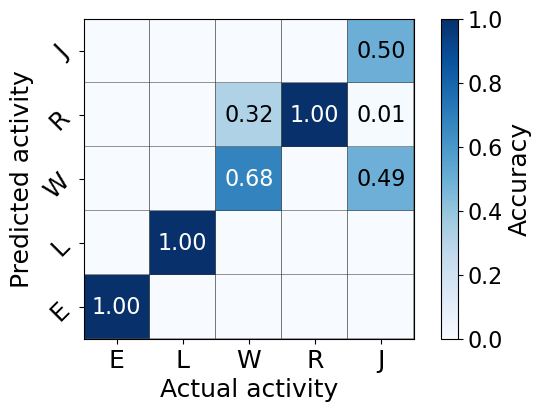

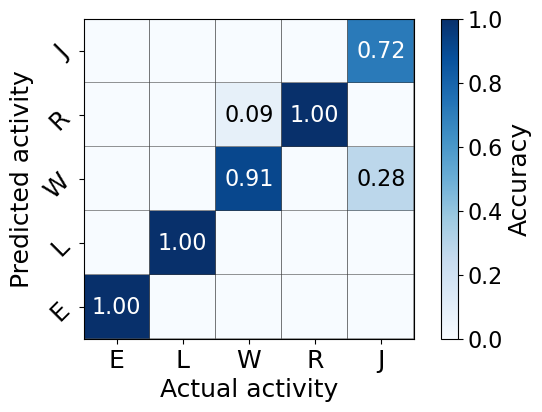

In [7]:
name_plot = name_file_init
plt_confusion_matrix(activities.shape[0], conf_matrix, activities=activities, name=name_plot)

name_plot = name_file_init + '_max_merge'
plt_confusion_matrix(activities.shape[0], conf_matrix_max_merge, activities=activities, name=name_plot)


#### Ratatuja

#### considerazioni
- riguardo al padding per avere la corretta concatenazione: alla fine del Reduction block i vari branch devono essere concatenati, i.e. i layer vengono messi in successione lungo la terza dimensione. Per questo è necessario che abbiano tutti la stessa shape (che è facilmente fissata dal MaxPool). Il fattore determinante per ridurre la dimensione del layer è la stride: a stride n corrisponde una riduzione circa di un fattore n (al momento n=2). Una volta fissate la stride e la dimensione del kernel, per ottenere esattamente la shape desiderata è necessario scegliere accuratamente il padding. Pytorch supporta vari metodi per specificare il padding: "same", "valid" (no padding), int o tupla. Con stride=1 il padding per i vari lati è calcolato automaticamente in modo da ottenere in outout la stessa shape dell'input! Quindi ci è molto utile, però funziona solamente per stride=1. Con tupla si può specificare qual è il padding ma solo nelle due direzioni, i.e. NON SUPPPORTA PADDING ASIMMETRICO. In generale possiamo specificare per i singoli casi qual è il padding necessario, ma ciò non è esauriente. Nel caso in cui abbiamo stride>1, se è necessario padding asimmetrico, dobbiamo aggiungerlo manualmente probabilmente con un metodo di functional ad hoc...

- nel right branch: i layer hanno kernel di dimensione crescente (FOV di dimensione crescente) per classificare features più estese man mano che si va più in profondità. Anche il numero delle feature maps cresce con la profondità.\
L'ultimo layer è quello che dimezza le dimensioni.

- durante il training: 1. calcolare i label predetti per una batch 2. calcolare la loss per una batch 3. effettuare la backpropagation con loss.backward() per ottenere i gradienti della loss rispetto ai prametri della NN 4. ottimizzare i parametri con un ottimizzatore con opt.step(), che usa i gradienti calcolati al punto precedente.

#### domande
- perchè vi sono esattamente 3 layer nel right branch? Cambia significativamente se si modifica il numero?
- come fa l'ottimizzatore a leggere i gradienti?

#### TODO
- eliminare ``cache file" nella
- provare a modificare l'ordine dei layers nell'ultimo branch per vedere se cambia? Forse inutile perchè perdo comprimerei l'informazione prima